# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

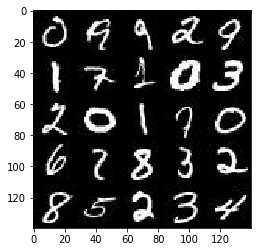

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

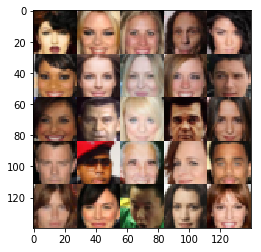

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image_inputs = tf.placeholder(tf.float32, 
                                      (None, image_width, image_height, image_channels),
                                      name='real_image_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_image_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        layer1 = tf.layers.conv2d(
            images, filters=64, kernel_size=5, strides=2, padding='same')
        layer1 = tf.maximum(layer1, layer1 * alpha)
        
        layer2 = tf.layers.conv2d(
            layer1, filters=128, kernel_size=5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(layer2, layer2 * alpha)

        layer3 = tf.layers.conv2d(
            layer2, filters=256, kernel_size=5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(layer3, layer3 * alpha)
        
        flatten_input = tf.reshape(layer3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flatten_input, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer1 = tf.layers.dense(z, 2 * 2 * 512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(layer1, layer1 * alpha)
        
        layer2 = tf.layers.conv2d_transpose(
            layer1, filters=256, kernel_size=5, strides=2, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2, layer2 * alpha)

        layer3 = tf.layers.conv2d_transpose(
            layer2, filters=128, kernel_size=5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(layer3, layer3 * alpha)
        
        logits = tf.layers.conv2d_transpose(
            layer3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        output = tf.tanh(logits)
        
    return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tf_vars = tf.trainable_variables()
    d_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in tf_vars if var.name.startswith('generator')]

    d_train_optimizer = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)


    operations = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_list = [opt for opt in operations if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_update_list):
        g_train_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_optimizer, g_train_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_images = 25
    index = 0 
    print_every = 10
    show_every = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                index += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_input: batch_images, 
                    z_input: z_sample,
                    lr: learning_rate
                })
                
                _ = sess.run(g_opt, feed_dict={
                    z_input: z_sample,
                    lr: learning_rate
                })
                
                if index % print_every == 0:
                    train_d_loss = d_loss.eval({
                        z_input: z_sample,
                        real_input: batch_images
                    })

                    train_g_loss = g_loss.eval({z_input: z_sample})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    losses.append((train_d_loss, train_g_loss))
                                
                if index % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

       
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8843... Generator Loss: 0.1799
Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 2.8115
Epoch 1/2... Discriminator Loss: 0.1960... Generator Loss: 2.8164
Epoch 1/2... Discriminator Loss: 0.0077... Generator Loss: 5.8408
Epoch 1/2... Discriminator Loss: 2.7316... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.4182
Epoch 1/2... Discriminator Loss: 2.0310... Generator Loss: 6.7711
Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 3.0757
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 1.9090
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.8092


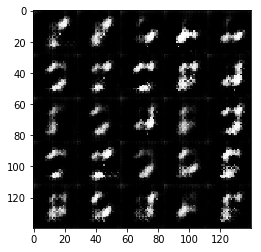

Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 1.6442
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.6626
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 1.7402
Epoch 1/2... Discriminator Loss: 0.2811... Generator Loss: 2.3197
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 5.0078
Epoch 1/2... Discriminator Loss: 0.4652... Generator Loss: 4.9171
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 4.3813
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 2.0851
Epoch 1/2... Discriminator Loss: 0.2926... Generator Loss: 2.9441


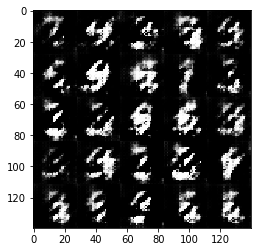

Epoch 1/2... Discriminator Loss: 1.1572... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 0.4436... Generator Loss: 1.9875
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 2.2194
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 3.7162
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 2.8398
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 2.2769
Epoch 1/2... Discriminator Loss: 0.4587... Generator Loss: 1.7567


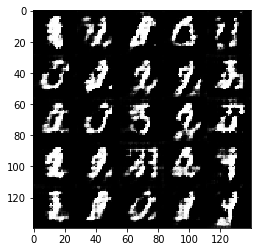

Epoch 1/2... Discriminator Loss: 1.8675... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 3.8615
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 3.2308
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 4.2367
Epoch 1/2... Discriminator Loss: 1.6505... Generator Loss: 0.3356
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 1.2934
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 0.6481... Generator Loss: 2.5087


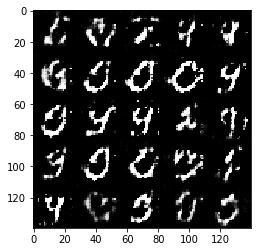

Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 2.9219
Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 4.6804
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.0358
Epoch 1/2... Discriminator Loss: 0.6646... Generator Loss: 1.6951
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 0.6939... Generator Loss: 1.6443


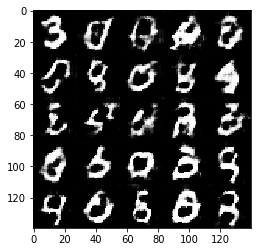

Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.7134
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 0.8958... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 0.6901... Generator Loss: 1.4559
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 1.4196
Epoch 1/2... Discriminator Loss: 0.6142... Generator Loss: 1.8604


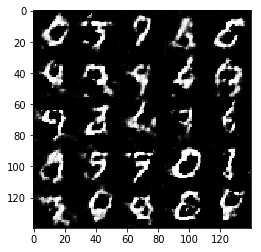

Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 3.0532
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.6918
Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.3506
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.4573
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 1.6349
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.1733


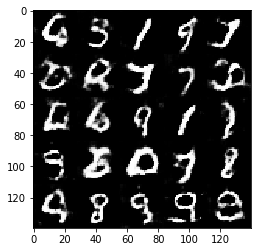

Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.3358
Epoch 1/2... Discriminator Loss: 0.8324... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.7548
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 2.0790
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 3.1325
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 1.7133


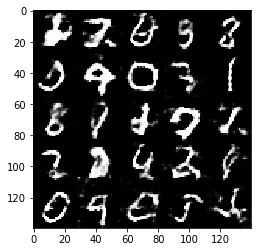

Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.2081
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.9439
Epoch 1/2... Discriminator Loss: 2.1838... Generator Loss: 0.2323
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 3.4424
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.3813
Epoch 1/2... Discriminator Loss: 2.1029... Generator Loss: 3.6866


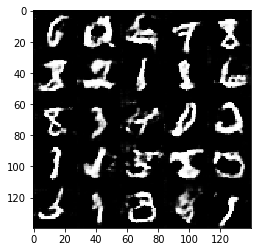

Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 1.4418
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 3.6340
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 2.1794
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.4618
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.7904... Generator Loss: 0.3535
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.6519


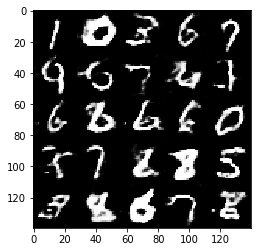

Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 2.5235
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.5366
Epoch 2/2... Discriminator Loss: 1.7560... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.6653
Epoch 2/2... Discriminator Loss: 1.6852... Generator Loss: 0.3083
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.4125


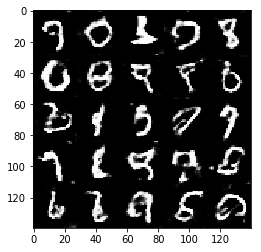

Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.2233
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.4881
Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.3853
Epoch 2/2... Discriminator Loss: 4.5639... Generator Loss: 0.0242
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 0.7073


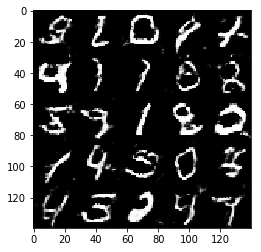

Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.5828
Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 2.1769
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.0582


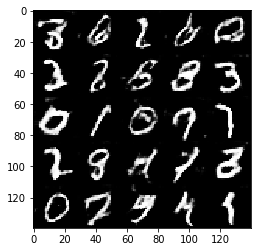

Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.1850... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 1.8056
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 1.6303


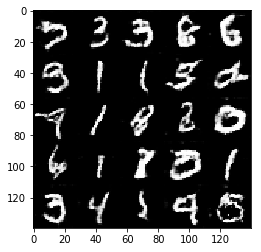

Epoch 2/2... Discriminator Loss: 1.8101... Generator Loss: 3.7594
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.8065
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.4456
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 1.9054... Generator Loss: 0.2655
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.1566


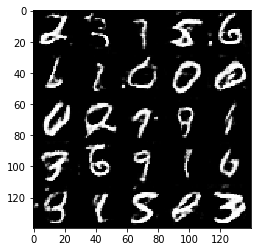

Epoch 2/2... Discriminator Loss: 4.8962... Generator Loss: 0.0195
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.5707
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.2980
Epoch 2/2... Discriminator Loss: 0.6305... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 2.2712... Generator Loss: 4.2473
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 1.8566... Generator Loss: 2.7860
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 0.9076


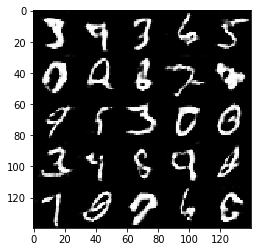

Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.3201
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.5610
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 1.4320
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 2.7444
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 3.0694
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.0139


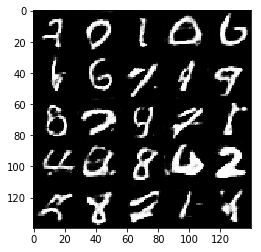

Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.3369
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.0824
Epoch 2/2... Discriminator Loss: 1.8125... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.2391
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 1.7873
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 1.9542
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.9310
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 0.5953


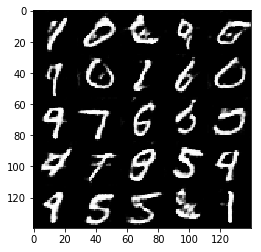

Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.7159
Epoch 2/2... Discriminator Loss: 1.5035... Generator Loss: 0.3706
Epoch 2/2... Discriminator Loss: 1.7787... Generator Loss: 0.3461
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 2.9726
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.4446


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#print(mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 2.9484
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 2.0420
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 3.9666
Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 6.7451
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 1.0549


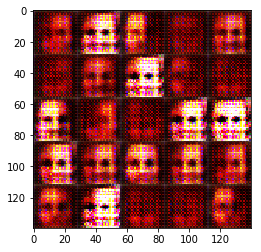

Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.3460
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 4.5879
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 3.7890
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 2.4666
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 3.5043
Epoch 1/1... Discriminator Loss: 0.3020... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 2.9724
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7767


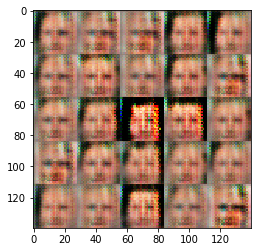

Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 2.3273
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 1.7720... Generator Loss: 3.9500
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.7981
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.1765
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.7331
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.6152


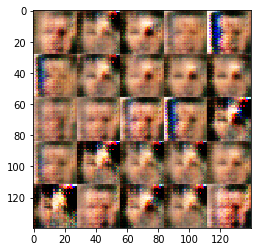

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.0040
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 2.0031... Generator Loss: 0.1946


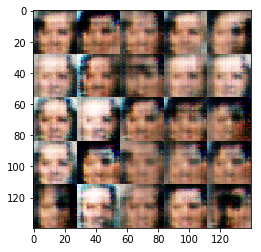

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 2.7369... Generator Loss: 0.1021
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.3204


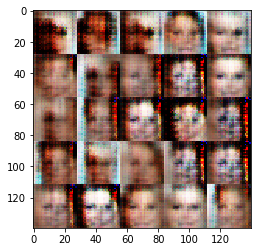

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.8413... Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.3340
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.9309... Generator Loss: 3.3142


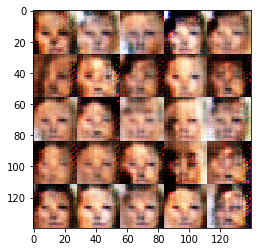

Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.4543
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 2.1740... Generator Loss: 0.1641
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.6199


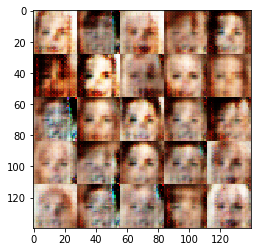

Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.6565
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.9837
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 1.8012


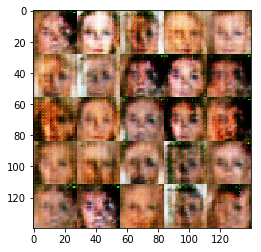

Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.3810
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.8843
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 2.0386
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 2.4236


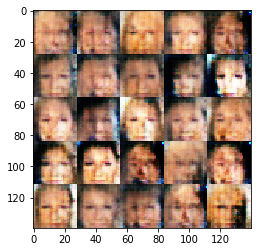

Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 2.4844
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 2.3436
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.7902
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6124


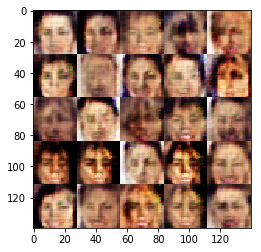

Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9091


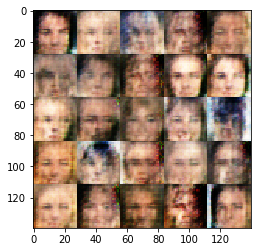

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 2.1553
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.6699


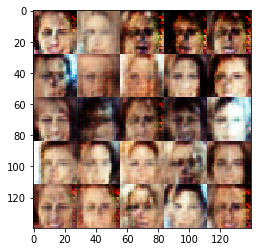

Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.7195... Generator Loss: 2.8701
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.8957


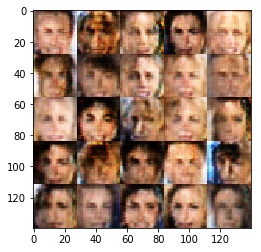

Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 2.1946
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 2.1660... Generator Loss: 2.6333
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 1.9431
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.9290


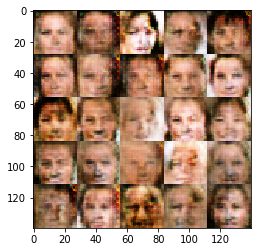

Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 2.1225
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.4233


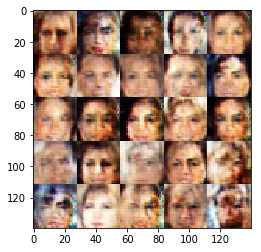

Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.7425
Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.3042


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.